In [2]:
import pyodbc
import pandas as pd
import credentials

In [11]:
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import seaborn as sn
from sklearn.metrics import confusion_matrix

In [12]:
import logging

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

import azureml.core
from azureml.core.experiment import Experiment
from azureml.core.workspace import Workspace
from azureml.train.automl import AutoMLConfig

In [6]:
crd = credentials.credentials

In [7]:
server = crd['server']
database = crd['database']
username = crd['username']
password = crd['password']
driver = crd['driver']

In [8]:
conx = pyodbc.connect("DRIVER="+driver+";SERVER="+server+";UID="+username+";PWD="+password+";DATABASE="+database)

In [37]:
pd_query = pd.read_sql_query("SELECT " \
                             "fact_id," \
                             "opp_id," \
                             "stage_id," \
                             "timestamp " \
                             "FROM Facts", \
                             conx)
facts = pd.DataFrame(pd_query, columns=['fact_id', 'opp_id', 'stage_id', 'timestamp'])

In [38]:
facts.head()

,fact_id,opp_id,stage_id,timestamp
0,1,1,1,2019-03-01
1,2,1,2,2019-03-16
2,3,1,3,2019-05-03
3,4,1,4,2019-05-08
4,5,2,1,2019-03-29


In [39]:
pd_query = pd.read_sql_query("SELECT opp_id, pid,acc_id,opp_size,is_aligned FROM Opportunities", conx)
opportunities = pd.DataFrame(pd_query, columns=['opp_id', 'pid', 'acc_id','opp_size','is_aligned'])

In [40]:
opportunities.head()

,opp_id,pid,acc_id,opp_size,is_aligned
0,1,1,1,2917716.00,True
1,2,1,1,2251076.00,True
2,3,1,1,2370825.00,True
3,4,1,1,2304975.00,True
4,5,1,1,1161842.00,True


In [41]:
facts = facts.set_index('opp_id').join(opportunities.set_index('opp_id'))
facts.reset_index(inplace=True)
facts.head()

,opp_id,fact_id,stage_id,timestamp,pid,acc_id,opp_size,is_aligned
0,1,1,1,2019-03-01,1,1,2917716.00,True
1,1,2,2,2019-03-16,1,1,2917716.00,True
2,1,3,3,2019-05-03,1,1,2917716.00,True
3,1,4,4,2019-05-08,1,1,2917716.00,True
4,2,5,1,2019-03-29,1,1,2251076.00,True


In [42]:
pd_query = pd.read_sql_query("SELECT * FROM Partners", conx)
partners = pd.DataFrame(pd_query, columns=['pid', 'name', 'size', 'location', 'p1_devs', 'p2_devs', 'alignment', 'partner_driven'])
partners.drop(columns=['alignment'], inplace=True)
partners = partners.rename(columns = {'size': 'partner_size', 
                                      'location': 'partner_loc',
                                      'name': 'partner_name'})

In [43]:
partners.head()

,pid,partner_name,partner_size,partner_loc,p1_devs,p2_devs,partner_driven
0,1,Rancity,large,1,51,17,True
1,2,Sail-In,large,3,39,10,True
2,3,Plushex,large,2,32,13,True
3,4,Drillace,large,2,38,10,True
4,5,Quoware,large,1,64,16,True


In [44]:
facts = facts.set_index('pid').join(partners.set_index('pid'))
facts.reset_index(inplace=True)
facts.head()

,pid,opp_id,fact_id,stage_id,timestamp,acc_id,opp_size,is_aligned,partner_name,partner_size,partner_loc,p1_devs,p2_devs,partner_driven
0,1,1,1,1,2019-03-01,1,2917716.00,True,Rancity,large,1,51,17,True
1,1,1,2,2,2019-03-16,1,2917716.00,True,Rancity,large,1,51,17,True
2,1,1,3,3,2019-05-03,1,2917716.00,True,Rancity,large,1,51,17,True
3,1,1,4,4,2019-05-08,1,2917716.00,True,Rancity,large,1,51,17,True
4,1,2,5,1,2019-03-29,1,2251076.00,True,Rancity,large,1,51,17,True


In [45]:
pd_query = pd.read_sql_query("SELECT * FROM Sales_Stages", conx)
stages = pd.DataFrame(pd_query, columns=['stage_id', 'sales_stage'])

In [46]:
stages.head()

,stage_id,sales_stage
0,1,Lead
1,2,Qualify
2,3,Solution
3,4,Proposal
4,5,Finalize


In [47]:
facts = facts.set_index('stage_id').join(stages.set_index('stage_id'))
facts.reset_index(inplace=True)
facts.head()

,stage_id,pid,opp_id,fact_id,timestamp,acc_id,opp_size,is_aligned,partner_name,partner_size,partner_loc,p1_devs,p2_devs,partner_driven,sales_stage
0,1,1,1,1,2019-03-01,1,2917716.00,True,Rancity,large,1,51,17,True,Lead
1,1,1,2,5,2019-03-29,1,2251076.00,True,Rancity,large,1,51,17,True,Lead
2,1,1,3,10,2019-04-24,1,2370825.00,True,Rancity,large,1,51,17,True,Lead
3,1,1,4,15,2018-02-10,1,2304975.00,True,Rancity,large,1,51,17,True,Lead
4,1,1,5,17,2019-12-08,1,1161842.00,True,Rancity,large,1,51,17,True,Lead


In [48]:
pd_query = pd.read_sql_query("SELECT id AS acc_id, * FROM Accounts", conx)
accounts = pd.DataFrame(pd_query, columns=['acc_id', 'name', 'size', 'location'])
accounts = accounts.rename(columns={'name': 'acc_name', 'size':'acc_size', 'location': 'acc_loc'})
accounts.head()

,acc_id,acc_name,acc_size,acc_loc
0,1,"snackwave chartreuse tilde,",large,1
1,2,croix velit polaroid.,large,1
2,3,"next tousled, intelligentsia",large,1
3,4,velit wolf kitsch,large,1
4,5,id tempor polaroid,large,1


In [49]:
facts = facts.set_index('acc_id').join(accounts.set_index('acc_id'))
facts.reset_index(inplace=True)
facts.head(10)

,acc_id,stage_id,pid,opp_id,fact_id,timestamp,opp_size,is_aligned,partner_name,partner_size,partner_loc,p1_devs,p2_devs,partner_driven,sales_stage,acc_name,acc_size,acc_loc
0,1,1,1,1,1,2019-03-01,2917716.00,True,Rancity,large,1,51,17,True,Lead,"snackwave chartreuse tilde,",large,1
1,1,1,1,2,5,2019-03-29,2251076.00,True,Rancity,large,1,51,17,True,Lead,"snackwave chartreuse tilde,",large,1
2,1,1,1,3,10,2019-04-24,2370825.00,True,Rancity,large,1,51,17,True,Lead,"snackwave chartreuse tilde,",large,1
3,1,1,1,4,15,2018-02-10,2304975.00,True,Rancity,large,1,51,17,True,Lead,"snackwave chartreuse tilde,",large,1
4,1,1,1,5,17,2019-12-08,1161842.00,True,Rancity,large,1,51,17,True,Lead,"snackwave chartreuse tilde,",large,1
5,1,1,1,6,22,2019-06-22,2750966.00,True,Rancity,large,1,51,17,True,Lead,"snackwave chartreuse tilde,",large,1
6,1,1,1,7,27,2019-04-24,2711342.00,True,Rancity,large,1,51,17,True,Lead,"snackwave chartreuse tilde,",large,1
7,1,1,1,8,32,2018-04-12,2883909.00,True,Rancity,large,1,51,17,True,Lead,"snackwave chartreuse tilde,",large,1
8,1,1,1,9,34,2019-02-05,2502122.00,False,Rancity,large,1,51,17,True,Lead,"snackwave chartreuse tilde,",large,1
9,1,1,1,10,38,2018-08-07,2624547.00,True,Rancity,large,1,51,17,True,Lead,"snackwave chartreuse tilde,",large,1


In [51]:
facts = facts[['opp_id','opp_size','partner_driven', 'partner_name', 'partner_size',
               'partner_loc', 'p1_devs','p2_devs', 'sales_stage',
               'acc_name', 'acc_size', 'acc_loc', 'is_aligned']]

In [52]:
facts.head()

,opp_id,opp_size,partner_driven,partner_name,partner_size,partner_loc,p1_devs,p2_devs,sales_stage,acc_name,acc_size,acc_loc,is_aligned
0,1,2917716.00,True,Rancity,large,1,51,17,Lead,"snackwave chartreuse tilde,",large,1,True
1,2,2251076.00,True,Rancity,large,1,51,17,Lead,"snackwave chartreuse tilde,",large,1,True
2,3,2370825.00,True,Rancity,large,1,51,17,Lead,"snackwave chartreuse tilde,",large,1,True
3,4,2304975.00,True,Rancity,large,1,51,17,Lead,"snackwave chartreuse tilde,",large,1,True
4,5,1161842.00,True,Rancity,large,1,51,17,Lead,"snackwave chartreuse tilde,",large,1,True


In [54]:
facts[facts.opp_id == 2]

,opp_id,opp_size,partner_driven,partner_name,partner_size,partner_loc,p1_devs,p2_devs,sales_stage,acc_name,acc_size,acc_loc,is_aligned
1,2,2251076.00,True,Rancity,large,1,51,17,Lead,"snackwave chartreuse tilde,",large,1,True
101,2,2251076.00,True,Rancity,large,1,51,17,Qualify,"snackwave chartreuse tilde,",large,1,True
121,2,2251076.00,True,Rancity,large,1,51,17,Solution,"snackwave chartreuse tilde,",large,1,True
137,2,2251076.00,True,Rancity,large,1,51,17,Proposal,"snackwave chartreuse tilde,",large,1,True
150,2,2251076.00,True,Rancity,large,1,51,17,Finalize,"snackwave chartreuse tilde,",large,1,True


## Build the Truth Dataset

In [141]:
solution = facts[facts.sales_stage == 'Solution']
proposal = facts[facts.sales_stage == 'Proposal']

In [142]:
solution.shape

(2518, 13)

In [57]:
proposal.shape

(776, 13)

In [58]:
proposal = proposal[['opp_id', 'sales_stage']]
proposal = proposal.rename(columns = {'sales_stage':'solution_stage'})
proposal.head()

,opp_id,solution_stage
136,1,Proposal
137,2,Proposal
138,3,Proposal
139,5,Proposal
140,6,Proposal


In [60]:
truth_df = solution.set_index('opp_id').join(proposal.set_index('opp_id'), how='left')
truth_df.reset_index(inplace=True)
truth_df['solution_stage'] = truth_df.solution_stage.fillna('Solution')
truth_df['solution_stage'] = truth_df.solution_stage.map({'Solution':0, 'Proposal':1})
truth_df = truth_df.rename(columns = {'solution_stage': 'win'})
truth_df.head()

,opp_id,opp_size,partner_driven,partner_name,partner_size,partner_loc,p1_devs,p2_devs,sales_stage,acc_name,acc_size,acc_loc,is_aligned,win
0,1,2917716.00,True,Rancity,large,1,51,17,Solution,"snackwave chartreuse tilde,",large,1,True,1
1,2,2251076.00,True,Rancity,large,1,51,17,Solution,"snackwave chartreuse tilde,",large,1,True,1
2,3,2370825.00,True,Rancity,large,1,51,17,Solution,"snackwave chartreuse tilde,",large,1,True,1
3,5,1161842.00,True,Rancity,large,1,51,17,Solution,"snackwave chartreuse tilde,",large,1,True,1
4,6,2750966.00,True,Rancity,large,1,51,17,Solution,"snackwave chartreuse tilde,",large,1,True,1


In [61]:
truth_df.win.value_counts()

0    1742
1     776
Name: win, dtype: int64

## Make columns into features

In [63]:
truth_df = truth_df[['opp_size', 'partner_driven', 
                     'partner_size','partner_loc', 'p1_devs', 'p2_devs',
                     'acc_size', 'acc_loc', 'is_aligned',
                     'win']]

In [64]:
truth_df.head()

,opp_size,partner_driven,partner_size,partner_loc,p1_devs,p2_devs,acc_size,acc_loc,is_aligned,win
0,2917716.00,True,large,1,51,17,large,1,True,1
1,2251076.00,True,large,1,51,17,large,1,True,1
2,2370825.00,True,large,1,51,17,large,1,True,1
3,1161842.00,True,large,1,51,17,large,1,True,1
4,2750966.00,True,large,1,51,17,large,1,True,1


In [65]:
def get_dummies(tdf, col_name, prefixs):
    tdf_dummies = pd.get_dummies(tdf[col_name], prefix=prefixs)
    tdf_dummies = tdf_dummies[tdf_dummies.columns[:-1]]
    tdf = pd.concat([tdf, tdf_dummies], axis=1)
    tdf.drop(columns=[col_name], inplace=True)
    return(tdf)

In [66]:
truth_df['is_aligned'] = truth_df.partner_driven.map({True: 1, False: 0})
truth_df['partner_driven'] = truth_df.partner_driven.map({True: 1, False: 0})
truth_df['partner_loc'] = truth_df.partner_loc.map({1:'West', 2:'Central', 3:'East'})
truth_df['acc_loc'] = truth_df.acc_loc.map({1:'West', 2:'Central', 3:'East'})
truth_df['partner_size'] = truth_df.partner_size.map({'large': 2, 'medium': 1, 'small': 0})
truth_df['acc_size'] = truth_df.acc_size.map({'large': 2, 'medium': 1, 'small': 0})
truth_df.head()

/anaconda/envs/azureml_py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/anaconda/envs/azureml_py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda/envs/azureml_py36/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cavea

,opp_size,partner_driven,partner_size,partner_loc,p1_devs,p2_devs,acc_size,acc_loc,is_aligned,win
0,2917716.00,1,2,West,51,17,2,West,1,1
1,2251076.00,1,2,West,51,17,2,West,1,1
2,2370825.00,1,2,West,51,17,2,West,1,1
3,1161842.00,1,2,West,51,17,2,West,1,1
4,2750966.00,1,2,West,51,17,2,West,1,1


In [67]:
truth_df = get_dummies(truth_df, 'partner_loc', 'p_loc')
truth_df = get_dummies(truth_df, 'acc_loc', 'a_loc')
truth_df.head()

,opp_size,partner_driven,partner_size,p1_devs,p2_devs,acc_size,is_aligned,win,p_loc_Central,p_loc_East,a_loc_Central,a_loc_East
0,2917716.00,1,2,51,17,2,1,1,0,0,0,0
1,2251076.00,1,2,51,17,2,1,1,0,0,0,0
2,2370825.00,1,2,51,17,2,1,1,0,0,0,0
3,1161842.00,1,2,51,17,2,1,1,0,0,0,0
4,2750966.00,1,2,51,17,2,1,1,0,0,0,0


In [68]:
truth_df = truth_df[['opp_size', 'partner_driven', 'partner_size', 'p1_devs', 'p2_devs',
                   'acc_size', 'p_loc_Central', 'p_loc_East',
                   'a_loc_Central', 'a_loc_East','is_aligned', 'win']]

In [69]:
truth_df.head()

,opp_size,partner_driven,partner_size,p1_devs,p2_devs,acc_size,p_loc_Central,p_loc_East,a_loc_Central,a_loc_East,is_aligned,win
0,2917716.00,1,2,51,17,2,0,0,0,0,1,1
1,2251076.00,1,2,51,17,2,0,0,0,0,1,1
2,2370825.00,1,2,51,17,2,0,0,0,0,1,1
3,1161842.00,1,2,51,17,2,0,0,0,0,1,1
4,2750966.00,1,2,51,17,2,0,0,0,0,1,1


## Engineering an Interaction Feature

## This is very Business Domain Specific.
### Need Interaction with Business Stake Holders

In [71]:
truth_df['p1p2'] = truth_df.p1_devs / truth_df.p2_devs
truth_df['p1p2'] = truth_df.p1p2.map(lambda x: (3 - x)**2)

In [72]:
truth_df['p1p2_2'] = truth_df.p1_devs / truth_df.p2_devs

In [125]:
feature_cols = ['opp_size', 'partner_driven', 'partner_size', 'p1_devs', 'p2_devs',
               'acc_size', 'p_loc_Central', 'p_loc_East',
               'a_loc_Central', 'a_loc_East', 'is_aligned', 'p1p2']

#feature_cols = ['p1_devs', 'p2_devs', 'p1p2']

#feature_cols = ['p1_devs', 'p2_devs', 'p1p2_2']

#feature_cols = ['p1_devs', 'p2_devs', 'p1p2_2', 'is_aligned']


X = truth_df[feature_cols]
y = truth_df.win

In [126]:
# use train/test split with different random_state values
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=4)

In [127]:
logreg = LogisticRegression(C=1e1)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print ('accuracy: ' + str(metrics.accuracy_score(y_test, y_pred)))
print ('precision: ' + str(metrics.precision_score(y_test, y_pred)))
print ('recall: ' + str(metrics.recall_score(y_test, y_pred)))

accuracy: 0.6714285714285714
precision: 1.0
recall: 0.004807692307692308


/anaconda/envs/azureml_py36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [128]:
confusion_matrix(y_test, y_pred)

array([[422,   0],
       [207,   1]])

In [130]:
dict(zip(feature_cols, list(logreg.coef_[0])))

{'opp_size': 2.964520989351696e-07,
 'partner_driven': -0.0004074710124623492,
 'partner_size': -0.00012961580908321113,
 'p1_devs': -0.019619057753452917,
 'p2_devs': -0.0022095419179726837,
 'acc_size': 0.00012331215177654726,
 'p_loc_Central': -0.0002857533217621963,
 'p_loc_East': -0.0001760070996732586,
 'a_loc_Central': -0.00020683526289119562,
 'a_loc_East': -0.0003053311482902769,
 'is_aligned': -0.0004074710124623492,
 'p1p2': -0.002429845456081964}

In [131]:
ws = Workspace.from_config()

# Choose a name for the experiment and specify the project folder.
experiment_name = 'automl-crm-classification'
project_folder = './sample_projects/automl-crm-classification'

experiment = Experiment(ws, experiment_name)

output = {}
output['SDK version'] = azureml.core.VERSION
output['Subscription ID'] = ws.subscription_id
output['Workspace Name'] = ws.name
output['Resource Group'] = ws.resource_group
output['Location'] = ws.location
output['Project Directory'] = project_folder
output['Experiment Name'] = experiment.name
pd.set_option('display.max_colwidth', -1)
outputDf = pd.DataFrame(data = output, index = [''])
outputDf.T

,
SDK version,1.0.83
Subscription ID,3c3bb71f-3a4c-436f-9e0a-7407d75a82fa
Workspace Name,dswdsectiona202001
Resource Group,2020-01-datascience-wdsectiona-rg
Location,southcentralus
Project Directory,./sample_projects/automl-crm-classification
Experiment Name,automl-crm-classification


(array([422.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 208.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

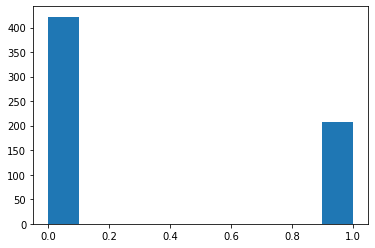

In [132]:
plt.hist(y_test)

In [133]:
feature_cols = ['opp_size', 'partner_driven', 'partner_size', 
                'p1_devs', 'p2_devs','acc_size', 'p_loc_Central', 'p_loc_East',
                'a_loc_Central','a_loc_East', 'p1p2_2', 'is_aligned']
label = "win"
all_cols = feature_cols + [label]

In [134]:
train_data, test_data = train_test_split(truth_df[all_cols], test_size=0.1, random_state=42)

In [135]:
automl_settings = {
    "iteration_timeout_minutes": 10,
    "iterations": 10,
    "n_cross_validations": 3,
    "verbosity": logging.INFO
}

automl_classifier = AutoMLConfig(task = 'classification',
                             primary_metric = 'AUC_weighted',
                             num_classes = 2,
                             featurization = 'auto',
                             model_explainability = True,
                             debug_log = 'crm_20200319.log',
                             path = project_folder,
                             training_data = train_data,
                             label_column_name = label,
                             **automl_settings
                            )

In [136]:
local_run = experiment.submit(automl_classifier, show_output = True)

Running on local machine
Parent Run ID: AutoML_319daac5-520d-43d7-8dbb-1bea312c63fa

Current status: DatasetFeaturization. Beginning to featurize the dataset.
Current status: DatasetEvaluation. Gathering dataset statistics.
Current status: FeaturesGeneration. Generating features for the dataset.
Current status: DatasetFeaturizationCompleted. Completed featurizing the dataset.
Current status: DatasetCrossValidationSplit. Generating individually featurized CV splits.

****************************************************************************************************
DATA GUARDRAILS: 

TYPE:         Class balancing detection
STATUS:       PASSED
DESCRIPTION:  Classes are balanced in the training data.

TYPE:         Missing values imputation
STATUS:       PASSED
DESCRIPTION:  There were no missing values found in the training data.

TYPE:         High cardinality feature detection
STATUS:       PASSED
DESCRIPTION:  Your inputs were analyzed, and no high cardinality features were detected

In [137]:
local_run

Experiment,Id,Type,Status,Details Page,Docs Page
automl-crm-classification,AutoML_319daac5-520d-43d7-8dbb-1bea312c63fa,automl,Completed,Link to Azure Machine Learning studio,Link to Documentation


In [138]:
# Select run with best score.
best_run, fitted_model = local_run.get_output()
print(best_run)

Run(Experiment: automl-crm-classification,
Id: AutoML_319daac5-520d-43d7-8dbb-1bea312c63fa_8,
Type: None,
Status: Completed)


WARNING - findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
WARNING - findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
WARNING - findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
WARNING - findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


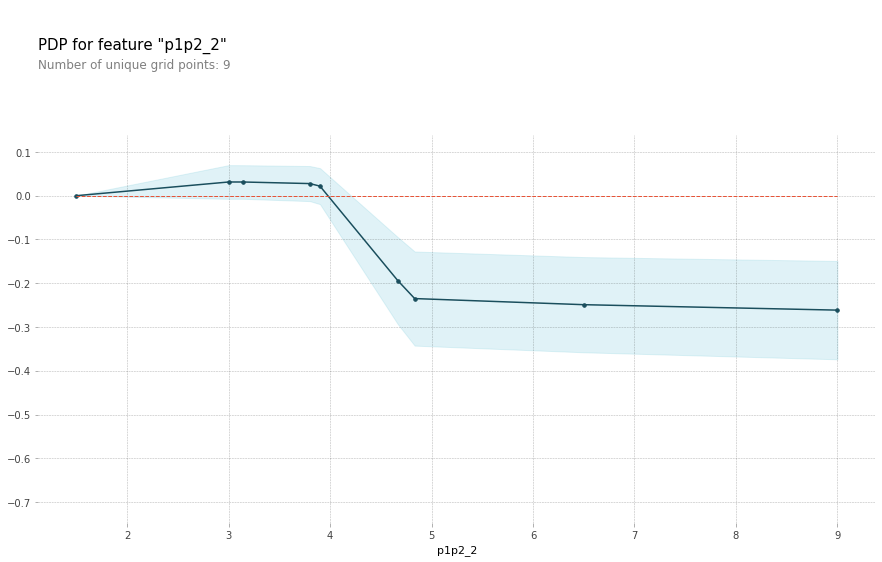

In [139]:
%matplotlib inline
from matplotlib import pyplot as plt
from pdpbox import pdp, get_dataset, info_plots

# Create the data that we will plot
pdp_goals = pdp.pdp_isolate(model=fitted_model, dataset=train_data, model_features=feature_cols, feature='p1p2_2')

# plot it
pdp.pdp_plot(pdp_goals, 'p1p2_2')
plt.show()